In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

from google.colab import drive
drive.mount('/content/drive')

worksheet = gc.open("titanic").sheet1
from gspread_dataframe import get_as_dataframe

df = get_as_dataframe(worksheet)

Mounted at /content/drive


In [27]:
titanic_df = df
titanic_df = titanic_df.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"], errors="ignore")

### One-Hot Encoding
One-hot encoding is a technique used to ensure that categorical variables are better represented in the machine. Let's take a look at the "Sex" column

In [29]:
for col in ["Sex", "Embarked"]:
    if col in titanic_df.columns:
        titanic_df = pd.get_dummies(titanic_df, prefix=col, columns=[col])

titanic_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.0,3.0,22.0,1.0,0.0,7.2500,False,True,False,False,True
1,1.0,1.0,38.0,1.0,0.0,71.2833,True,False,True,False,False
2,1.0,3.0,26.0,0.0,0.0,7.9250,True,False,False,False,True
3,1.0,1.0,35.0,1.0,0.0,53.1000,True,False,False,False,True
4,0.0,3.0,35.0,0.0,0.0,8.0500,False,True,False,False,True


Machine Learning classifiers don't know how to handle strings. As a result, you need to convert it into a categorical representation. There are two main ways to go about this:

Label Encoding: Assigning, for example, 0 for "male" and 1 for "female". The problem here is it intrinsically makes one category "larger than" the other category.

One-hot encoding: Assigning, for example, [1, 0] for "male" and [0, 1] for female. In this case, you have an array of size (n_categories,) and you represent a 1 in the correct index, and 0 elsewhere. In Pandas, this would show as extra columns. For example, rather than having a "Sex" column, it would be a "Sex_male" and "Sex_female" column. Then, if the person is male, it would simply show as a 1 in the "Sex_male" column and a 0 in the "Sex_female" column.

There is a nice and easy method that does this in pandas: get_dummies()

In [30]:
X = titanic_df.drop("Survived", axis=1)
y = titanic_df["Survived"]

In [41]:
print("✅ Final features used for training:")
print(X.columns.tolist())

✅ Final features used for training:
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']


In [32]:
X_train_full, X_temp, y_train_full, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [23]:
titanic_df = titanic_df.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"], errors="ignore")
titanic_df = pd.get_dummies(titanic_df, prefix="Sex", columns=["Sex"])
titanic_df = pd.get_dummies(titanic_df, prefix="Embarked", columns=["Embarked"])

X = titanic_df.drop("Survived", axis=1)
y = titanic_df["Survived"]

X_train_full, X_temp, y_train_full, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [33]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_full, y_train_full)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_full, y_train_full)

DecisionTreeClassifier(random_state=42)

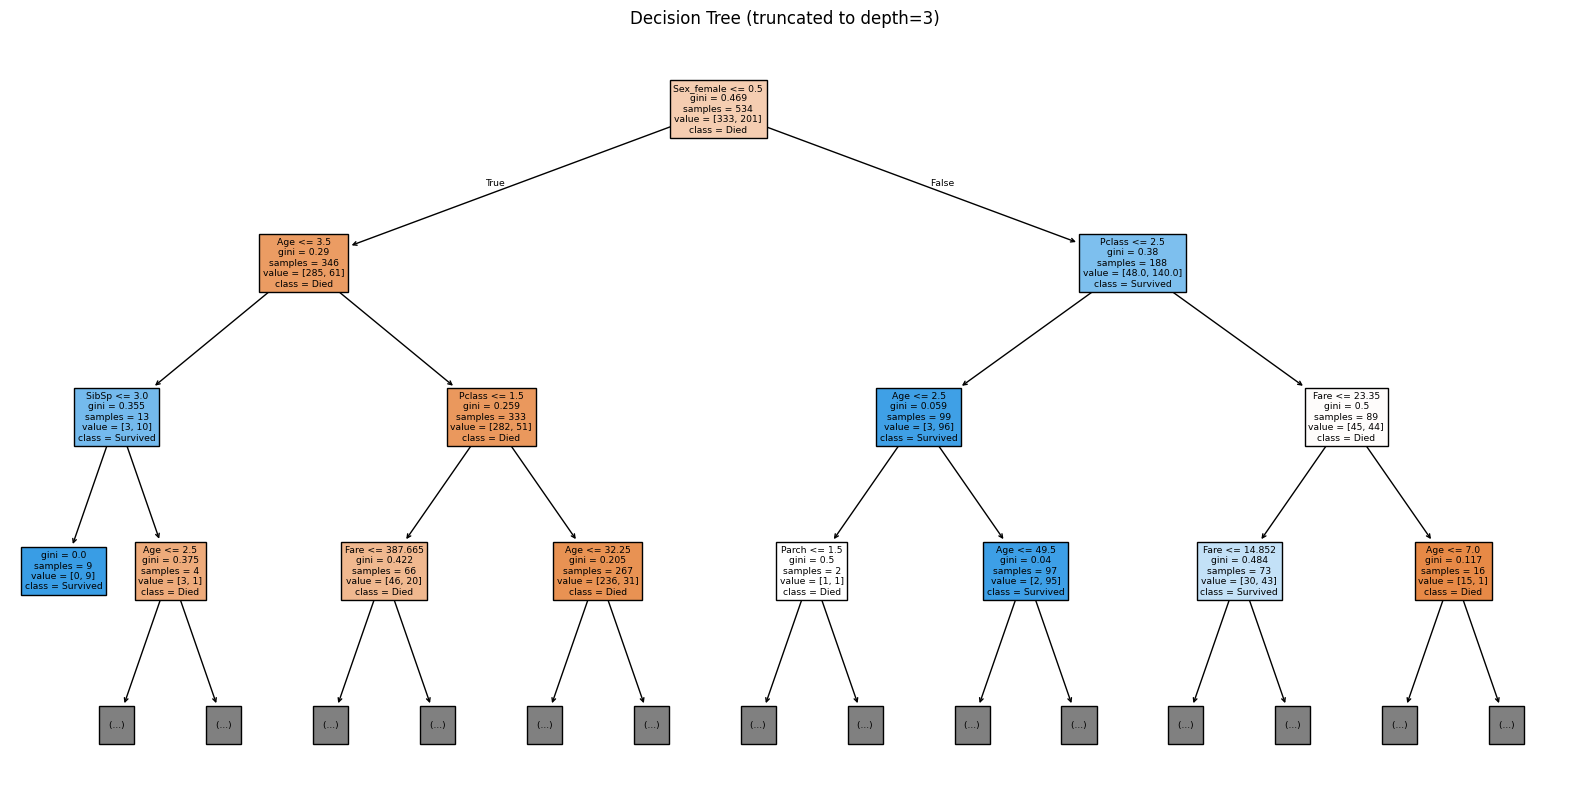

In [34]:
plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=X.columns, class_names=["Died", "Survived"], filled=True, max_depth=3)
plt.title("Decision Tree (truncated to depth=3)")
plt.show()

In [35]:
dev_acc_unlimited = accuracy_score(y_dev, clf.predict(X_dev))
print("Development Set Accuracy (no max_depth):", round(dev_acc_unlimited, 4))

Development Set Accuracy (no max_depth): 0.7135


In [36]:
depths = list(range(2, 11))
train_accuracies = []
dev_accuracies = []

In [37]:
for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train_full, y_train_full)
    train_accuracies.append(accuracy_score(y_train_full, model.predict(X_train_full)))
    dev_accuracies.append(accuracy_score(y_dev, model.predict(X_dev)))

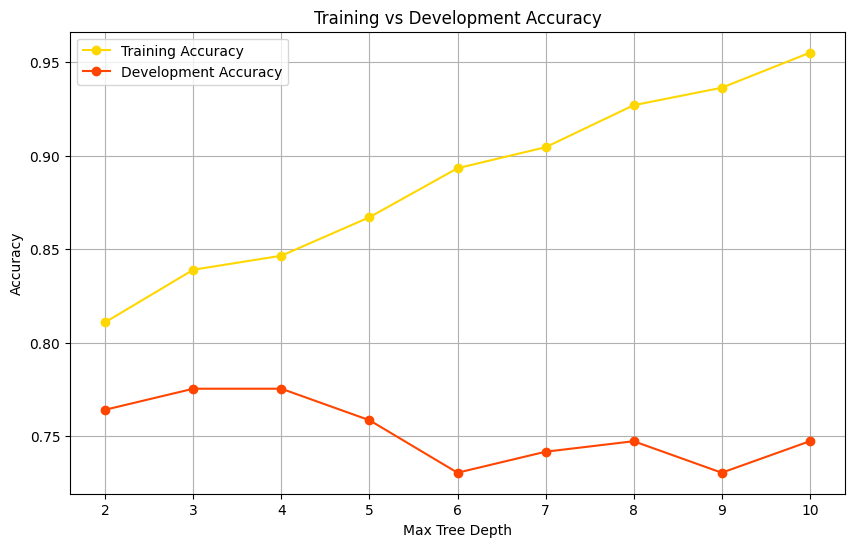

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(depths, train_accuracies, label="Training Accuracy", marker='o', color='gold')
plt.plot(depths, dev_accuracies, label="Development Accuracy", marker='o', color='orangered')
plt.xlabel("Max Tree Depth")
plt.ylabel("Accuracy")
plt.title("Training vs Development Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [39]:
best_depth = depths[dev_accuracies.index(max(dev_accuracies))]
final_model = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
final_model.fit(X_train_full, y_train_full)
test_accuracy = accuracy_score(y_test, final_model.predict(X_test))

As I increased the max_depth of the decision tree from 2 to 10, the training accuracy steadily increased, approaching 100%. This is expected as a deeper tree can fit the training data better.

Also, the development accuracy increased initially, peaked, and then started to decline. This behavior indicates overfitting.

In [40]:
print("Best max_depth:", best_depth)
print("Test Set Accuracy:", round(test_accuracy, 4))

Best max_depth: 3
Test Set Accuracy: 0.8212
